In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense,LeakyReLU,Conv2D,Reshape,Conv2DTranspose,Lambda,BatchNormalization,Dropout,ReLU,UpSampling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(1)

2 Physical GPUs, 2 Logical GPUs


In [66]:
data = np.load('full_numpy_bitmap_camel.npy')
data.shape

(121399, 784)

(28, 28, 1)
(128, 128)


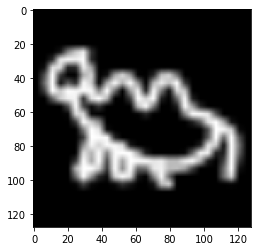

In [3]:
import cv2
import matplotlib.pyplot as plt
test_img = data[0].reshape(28,28,1)
# test_img = cv2.cvtColor(test_img)
test_img = np.array(test_img)
print(test_img.shape)
test_img = cv2.resize(test_img,(128,128))
print(test_img.shape)
plt.imshow(test_img,cmap='gray')

In [92]:
import cv2

dataset = []
for i in range(len(data)):
    img = data[i].reshape(28,28,1)
    dataset.append(img)
dataset = np.array(dataset)
print(dataset.shape)
dataset.shape
dataset = dataset/255.0

(121399, 28, 28, 1)


In [5]:
from sklearn.model_selection import train_test_split

train_x, test_x = train_test_split(dataset,test_size=0.2,shuffle=True)

In [6]:
print(train_x.shape)
print(test_x.shape)

(40000, 28, 28, 1)
(10000, 28, 28, 1)


In [93]:
# model determining

def GANdescriminative(input_shape = (28,28,1)):
    input = Input(shape=input_shape)
    conv1 = Conv2D(64,kernel_size=5, strides=2,padding='same')(input)
    activation1 = ReLU()(conv1)
    dropout1 = Dropout(0.4)(activation1)
    conv2 = Conv2D(64,kernel_size=5, strides=2,padding='same')(dropout1)
    activation2 = ReLU()(conv2)
    before_number = K.int_shape(activation2)[1:]
    dropout2 = Dropout(0.4)(activation2)
    conv3 = Conv2D(128,kernel_size=5, strides=2,padding='same')(dropout2)
    activation3 = ReLU()(conv3)
    dropout3 = Dropout(0.4)(activation3)
    
    conv4 = Conv2D(128,kernel_size=5, strides=1,padding='same')(dropout3)
    activation4 = ReLU()(conv4)
    dropout4 = Dropout(0.4)(activation4)
    flatten = Flatten()(dropout4)
    output = Dense(1,activation='sigmoid')(flatten)
    model = Model(input,output)
    return model, before_number


In [94]:
mod,number = GANdescriminative()
mod.summary()
print(number)

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 14, 14, 64)        1664      
_________________________________________________________________
re_lu_125 (ReLU)             (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 7, 7, 64)          102464    
_________________________________________________________________
re_lu_126 (ReLU)             (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 7, 7, 64)          0  

In [95]:
def GANGenerative(k,input_shape=(100,)):
    input = Input(shape=input_shape)
    dense_1 = Dense(np.prod(k))(input)
    batch = BatchNormalization()(dense_1)
    activation1 = ReLU()(batch)
    reshape = Reshape(k)(activation1)
    upsampling1 = UpSampling2D(size=(2, 2))(reshape)
    conv1 = Conv2D(128,kernel_size=5,strides=1,padding='same')(upsampling1)
    batch2 = BatchNormalization()(conv1)
    activation2 = ReLU()(batch2)
    upsampling2 = UpSampling2D(size=(2,2))(activation2)
    conv2 = Conv2D(64,kernel_size=5,strides=1,padding='same')(upsampling2)
    batch3 = BatchNormalization()(conv2)
    activation3 = ReLU()(batch3)
    conv3 = Conv2D(64,kernel_size=5,strides=1,padding='same')(activation3)
    batch4 = BatchNormalization()(conv3)
    activation4 = ReLU()(batch4)
    conv5 = Conv2D(1,kernel_size=5,strides=1,padding='same')(activation4)
    output = ReLU()(conv5)
    model = Model(input,output)
    return model

In [31]:
aaaa = GANGenerative(number)
aaaa.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
re_lu_44 (ReLU)              (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 128)       2049

In [113]:
discriminator,k = GANdescriminative()
generator = GANGenerative(k)
discriminator.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0008),loss = 'binary_crossentropy',metrics=['accuracy'])
discriminator.trainable = False
model_input = Input(shape=(100,))
model_output = discriminator(generator(model_input))
model = Model(model_input,model_output)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0004),loss = 'binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_46 (Model)             (None, 28, 28, 1)         844161    
_________________________________________________________________
model_45 (Model)             (None, 1)                 720833    
Total params: 1,564,994
Trainable params: 837,377
Non-trainable params: 727,617
_________________________________________________________________


In [114]:
def train_discriminator(x_train,batch_size):
    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0,x_train.shape[0],batch_size)
    true_imgs = x_train[idx]
    # discriminator.train_on_batch(true_imgs,valid)
    # real image discriminative
    noise = np.random.normal(0,1,(batch_size,100))
    gen_imgs = generator.predict(noise)
    # discriminator.train_on_batch(gen_imgs,fake)
    # noise image
    d_loss_real, d_acc_real = discriminator.train_on_batch(true_imgs, valid)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, 100))
    return model.train_on_batch(noise, valid)


In [115]:
 def train(x_train, batch_size, epochs, print_every_n_batches = 200, using_generator = False):
        d_losses = []
        g_losses = []
        epoch = 0
        for epoch in range(epoch, epoch + epochs):

            d = train_discriminator(x_train, batch_size)
            g = train_generator(batch_size)
            if epoch % print_every_n_batches == 0:
                print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))
                r, c = 5, 5
                noise = np.random.normal(0, 1, (r * c, 100))
                gen_imgs = generator.predict(noise)

                gen_imgs = 0.5 * (gen_imgs + 1)
                gen_imgs = np.clip(gen_imgs, 0, 1)

                fig, axs = plt.subplots(r, c, figsize=(15,15))
                cnt = 0

                for i in range(r):
                    for j in range(c):
                        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                        axs[i,j].axis('off')
                        cnt += 1

            d_losses.append(d)
            g_losses.append(g)
            epoch += 1

        return d_losses,g_losses 

0 [D loss: (0.766)(R 0.685, F 0.847)] [D acc: (0.383)(0.766, 0.000)] [G loss: 0.664] [G acc: 1.000]
200 [D loss: (0.429)(R 0.416, F 0.441)] [D acc: (0.773)(0.797, 0.750)] [G loss: 2.400] [G acc: 0.016]
400 [D loss: (0.675)(R 0.431, F 0.919)] [D acc: (0.656)(0.797, 0.516)] [G loss: 1.837] [G acc: 0.078]
600 [D loss: (0.360)(R 0.376, F 0.345)] [D acc: (0.828)(0.781, 0.875)] [G loss: 3.427] [G acc: 0.000]
800 [D loss: (0.416)(R 0.395, F 0.436)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.858] [G acc: 0.094]
1000 [D loss: (0.442)(R 0.742, F 0.141)] [D acc: (0.781)(0.578, 0.984)] [G loss: 3.226] [G acc: 0.016]
1200 [D loss: (0.310)(R 0.338, F 0.282)] [D acc: (0.812)(0.750, 0.875)] [G loss: 4.109] [G acc: 0.000]
1400 [D loss: (0.406)(R 0.418, F 0.394)] [D acc: (0.836)(0.828, 0.844)] [G loss: 3.242] [G acc: 0.031]
1600 [D loss: (0.401)(R 0.420, F 0.382)] [D acc: (0.812)(0.781, 0.844)] [G loss: 3.034] [G acc: 0.047]
1800 [D loss: (0.159)(R 0.165, F 0.154)] [D acc: (0.930)(0.906, 0.953)] [G loss:

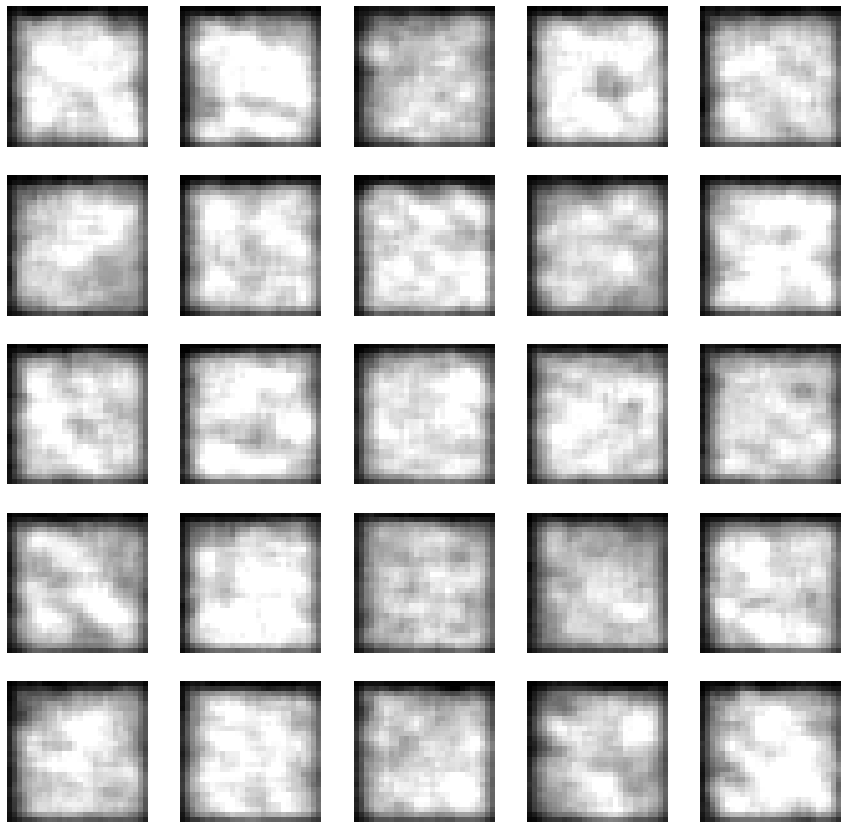

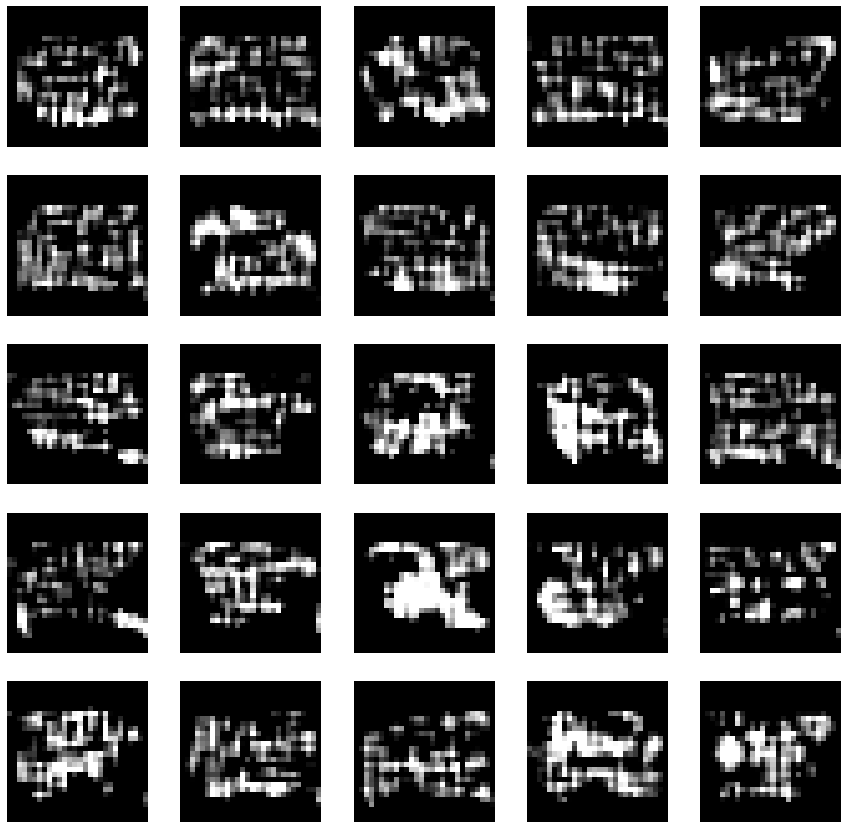

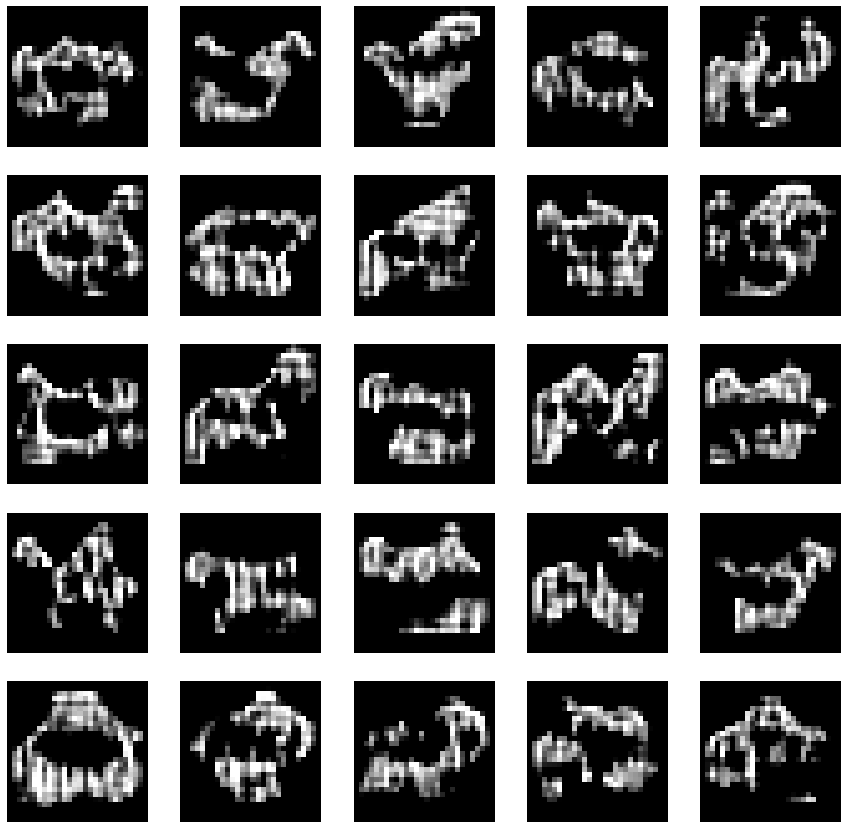

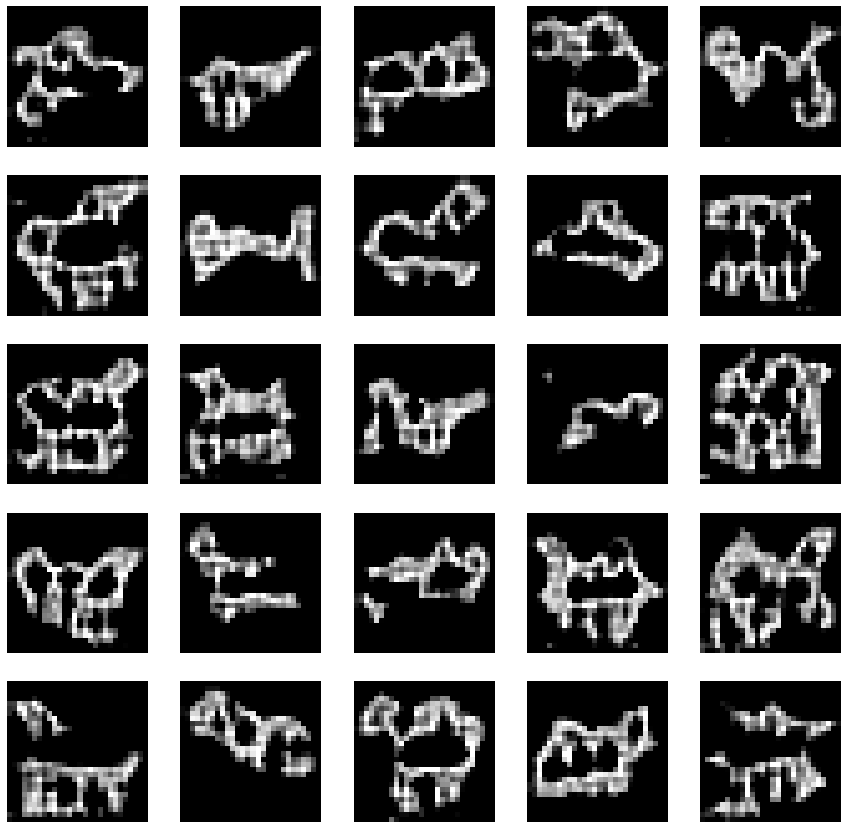

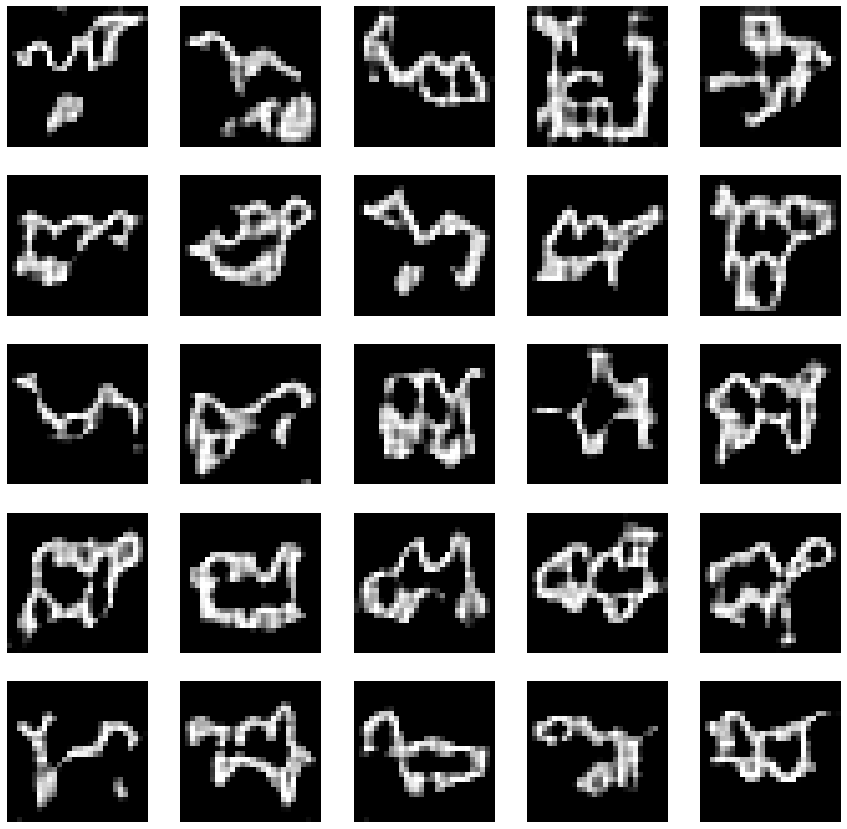

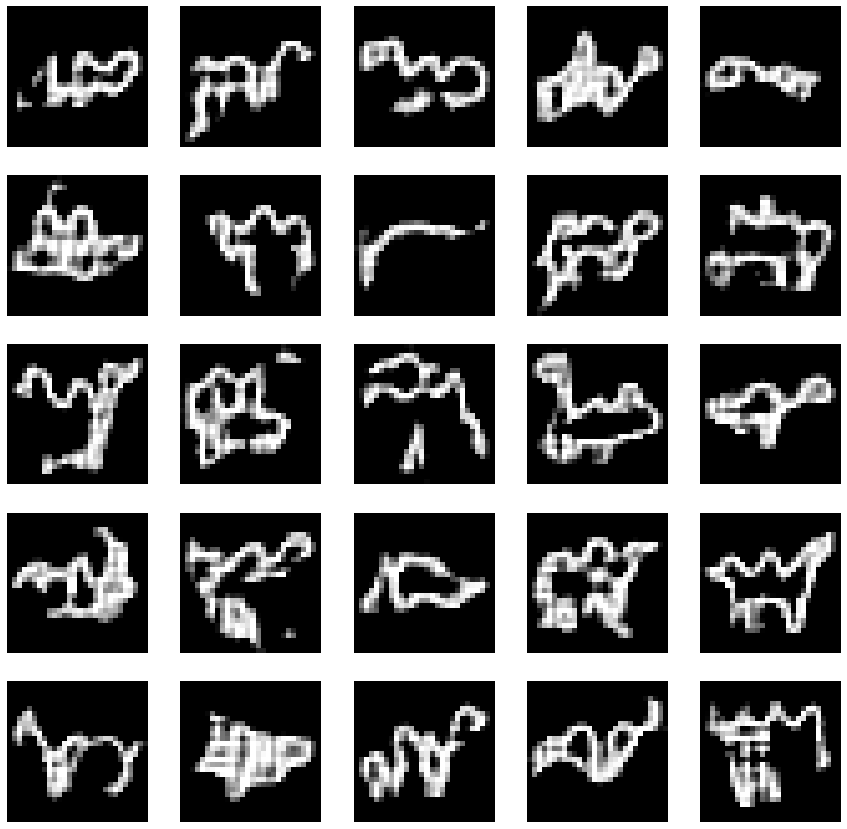

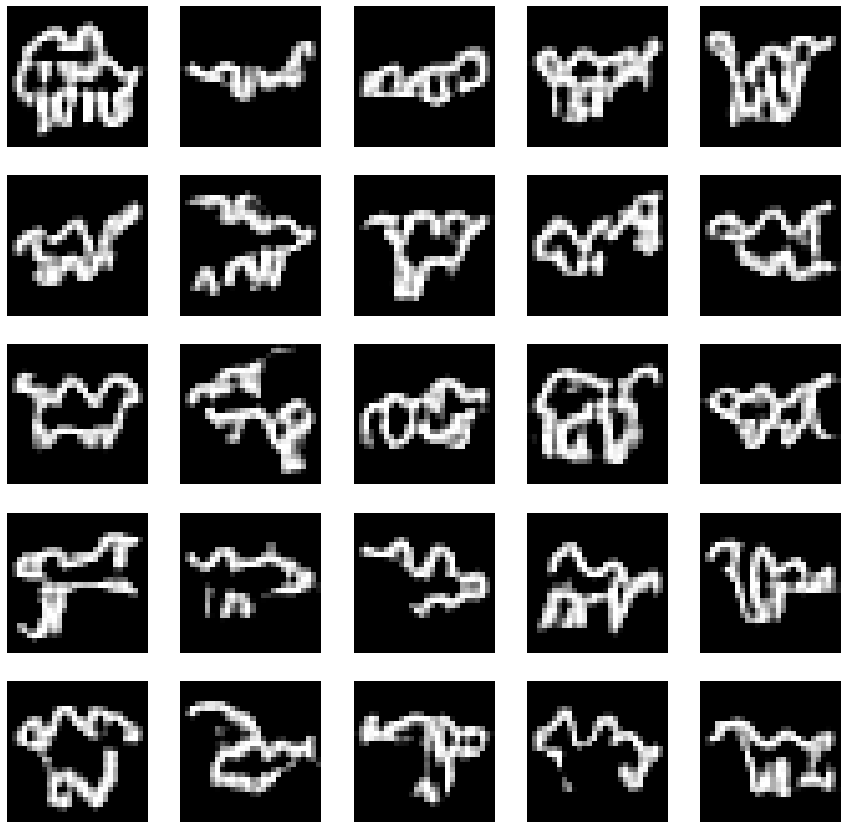

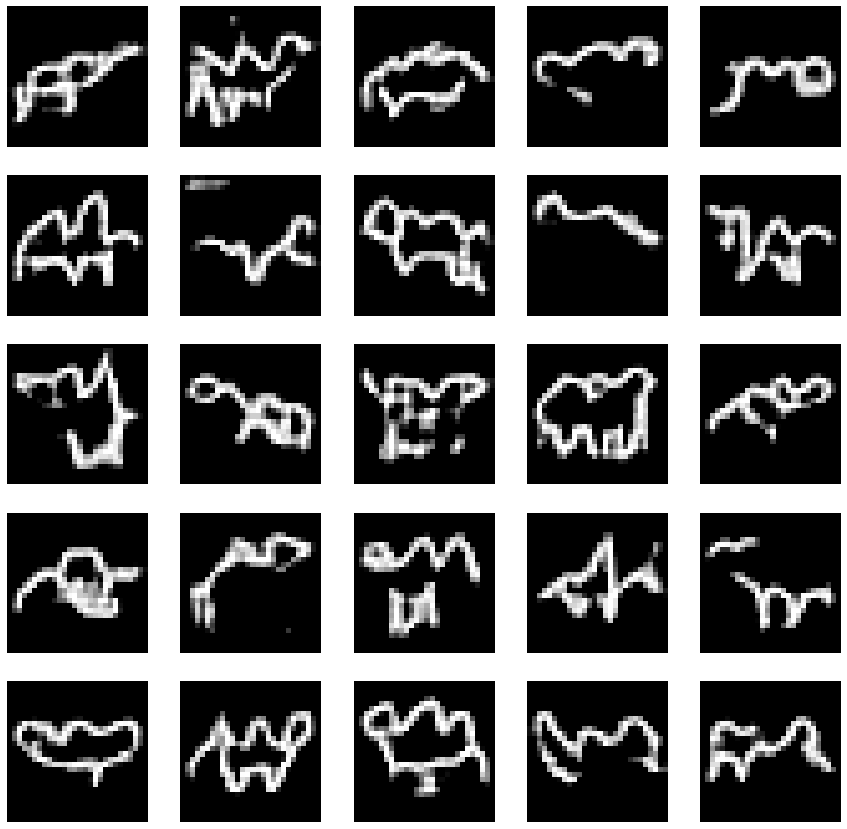

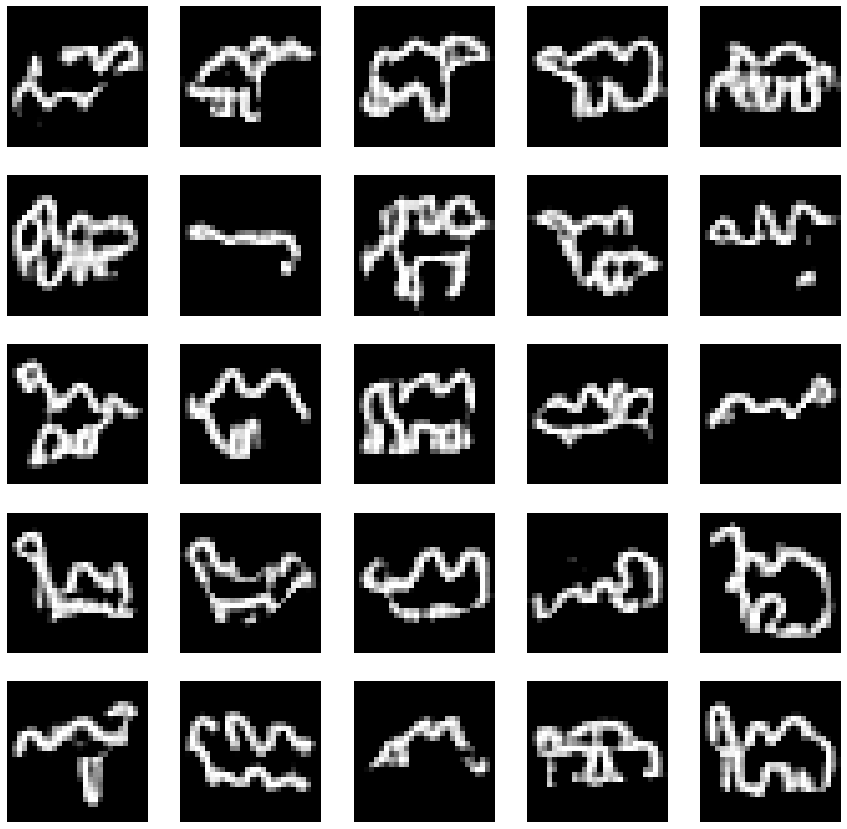

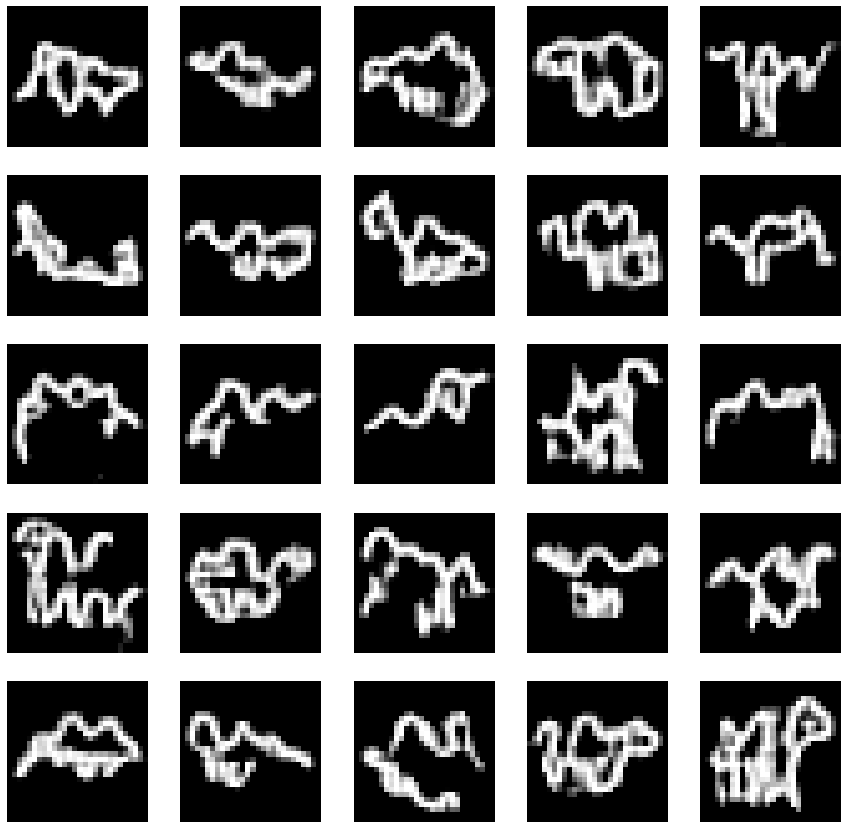

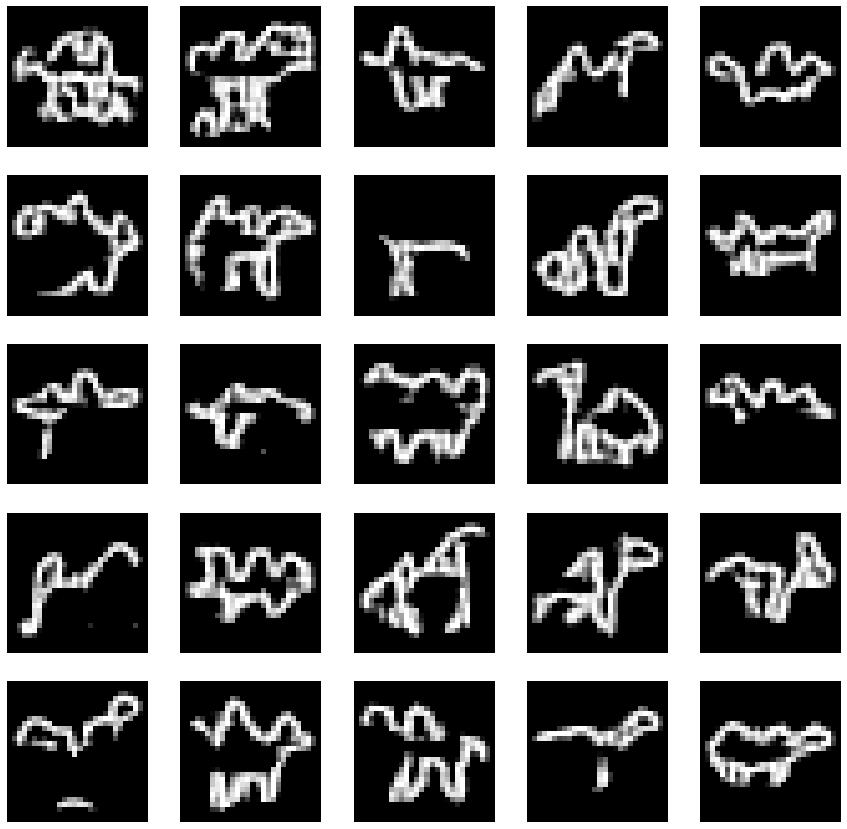

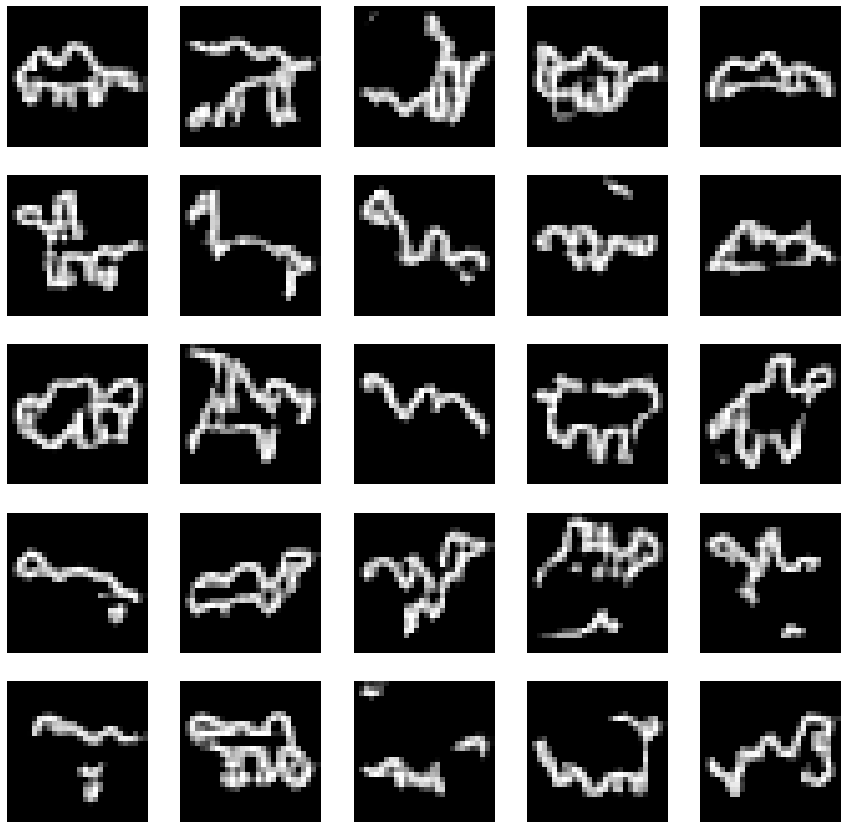

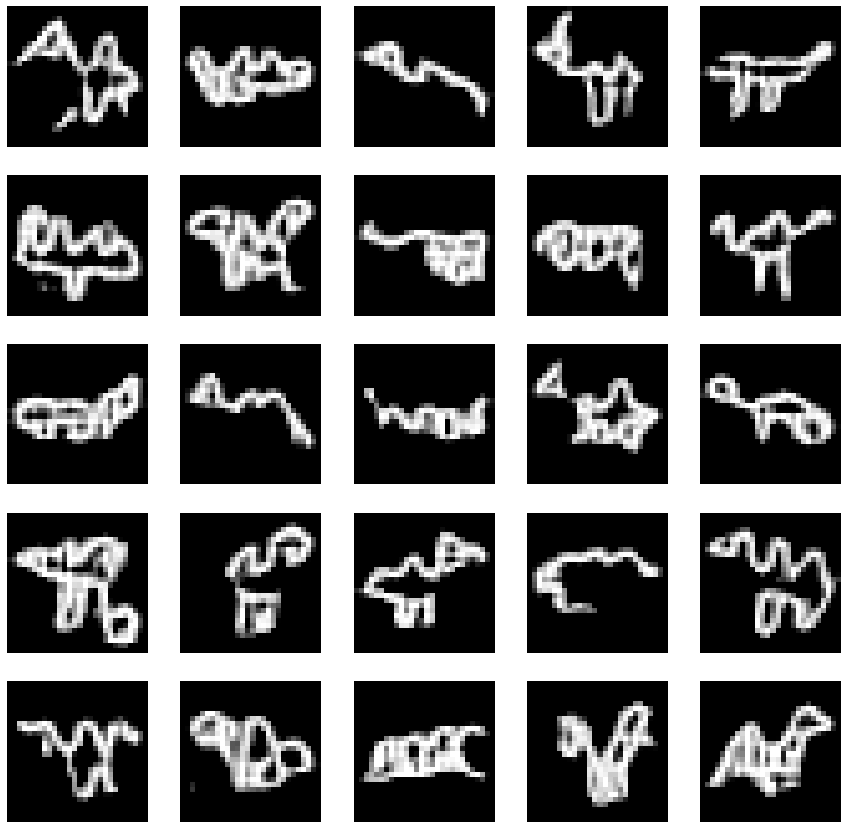

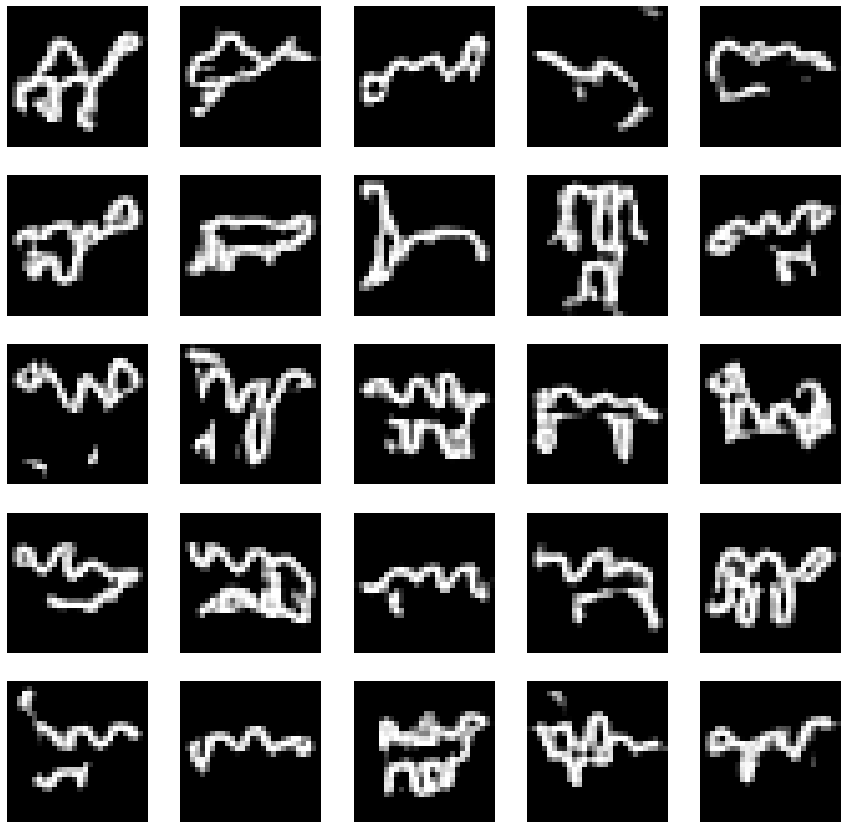

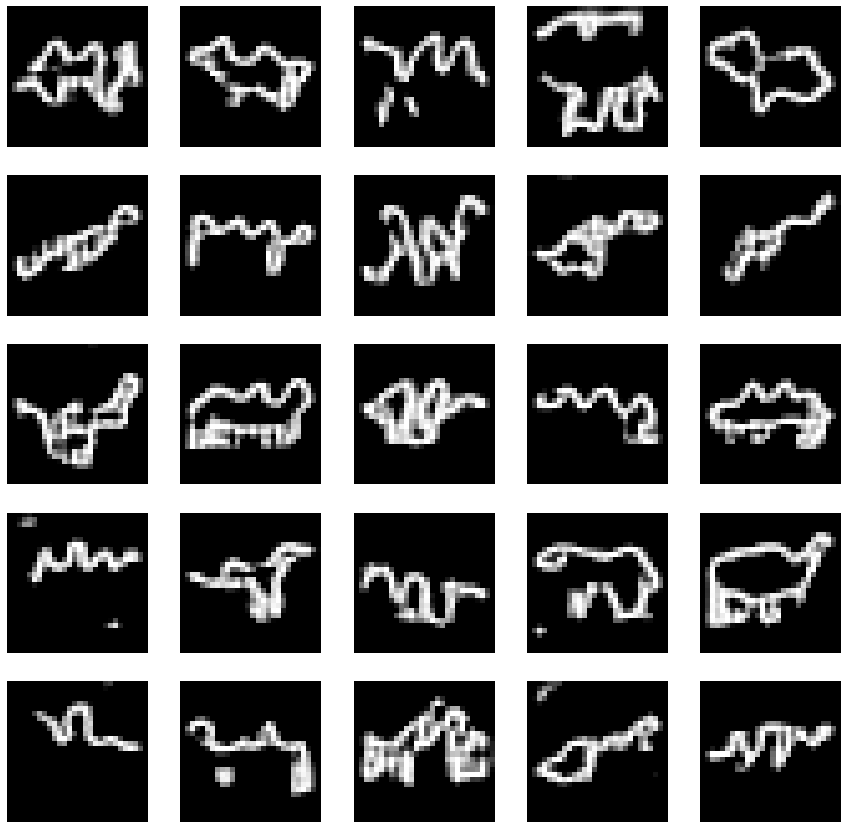

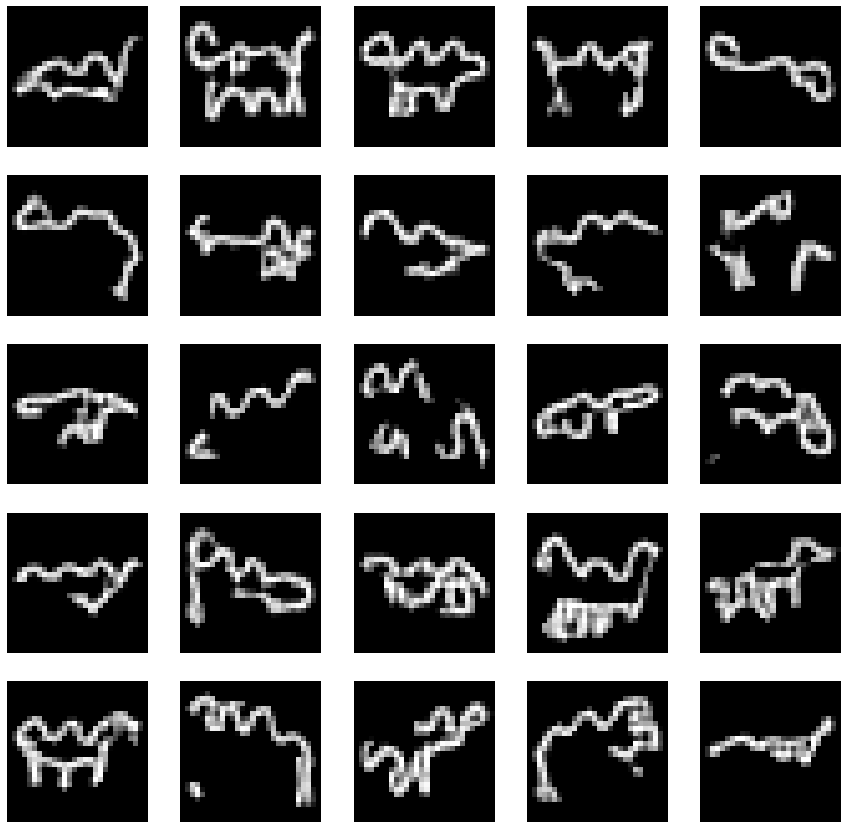

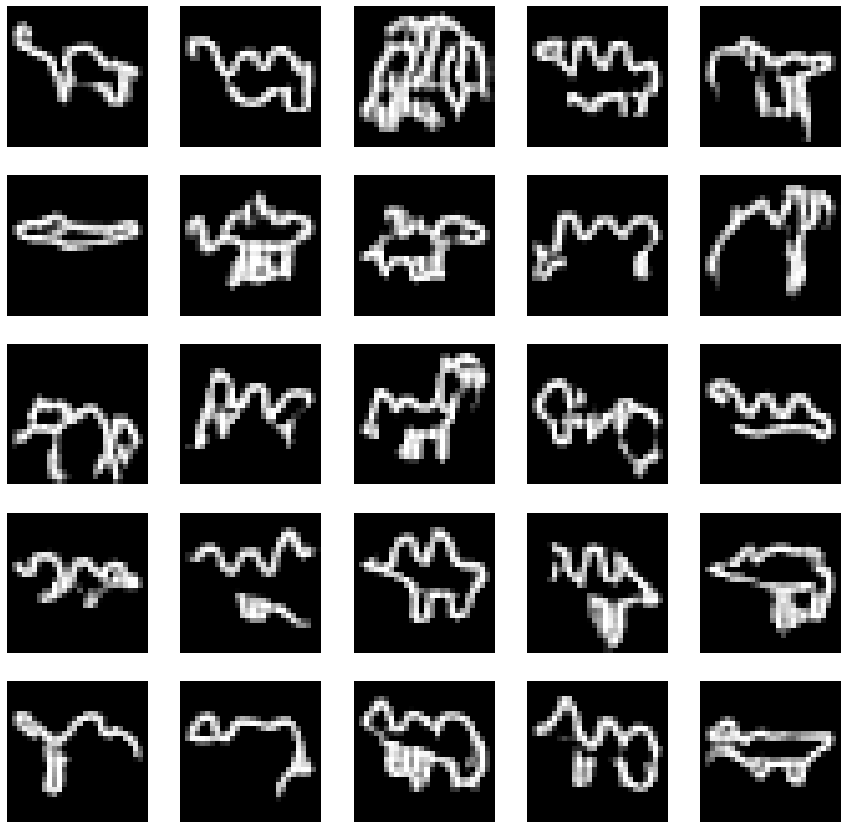

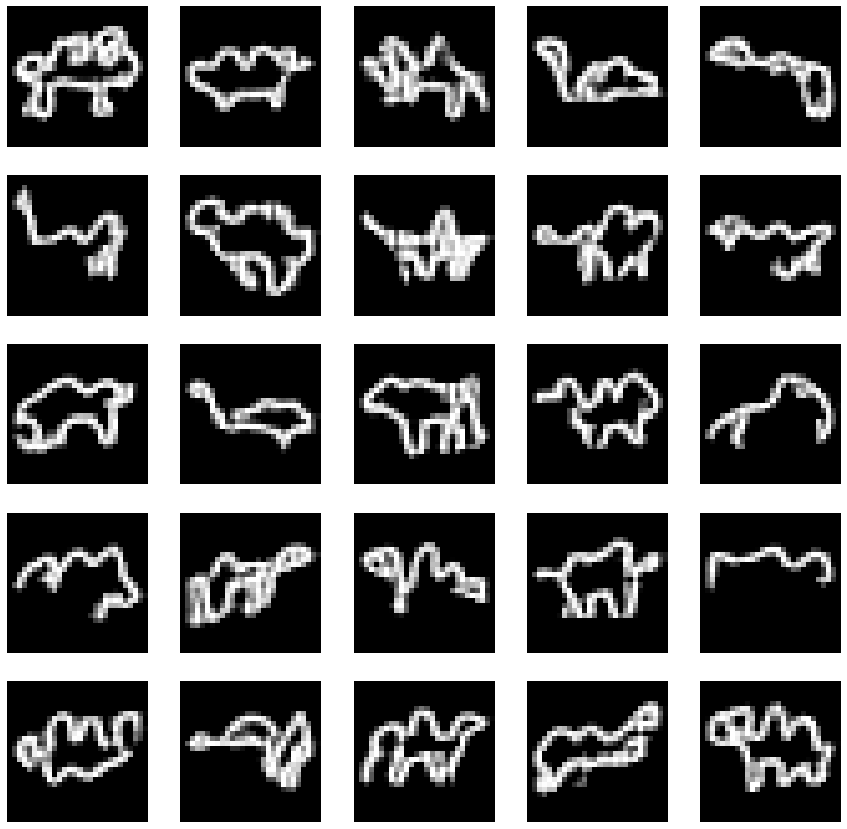

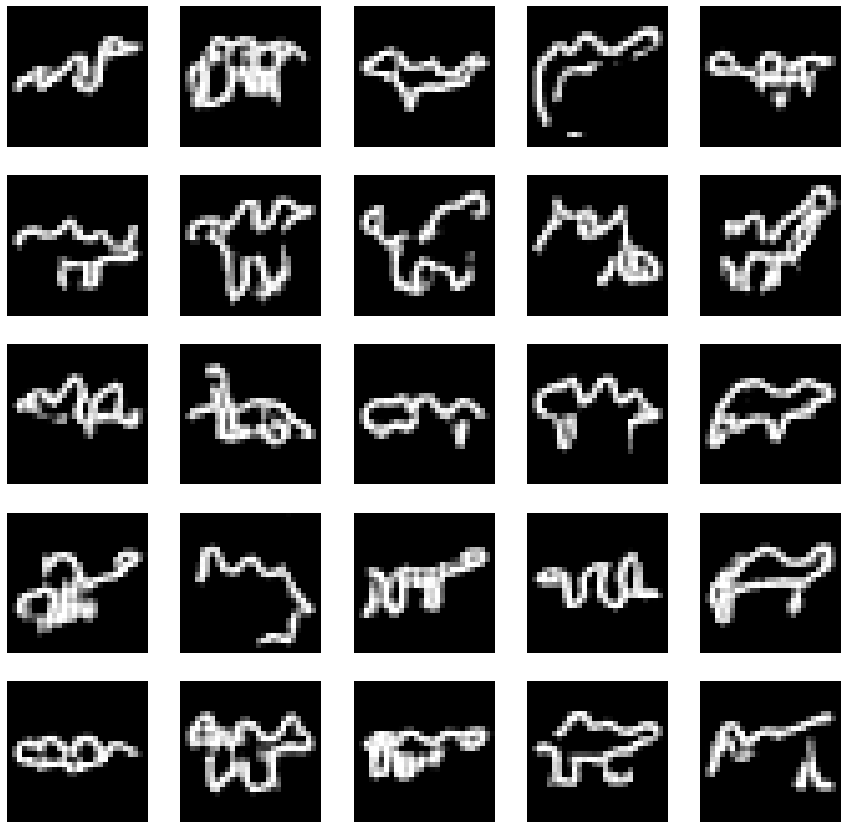

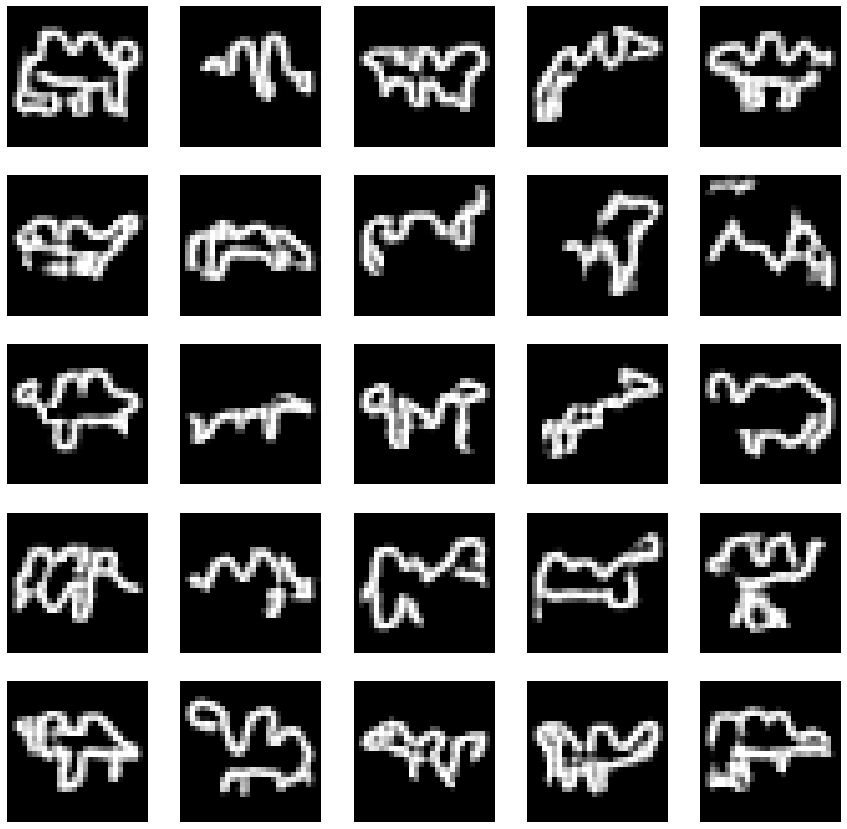

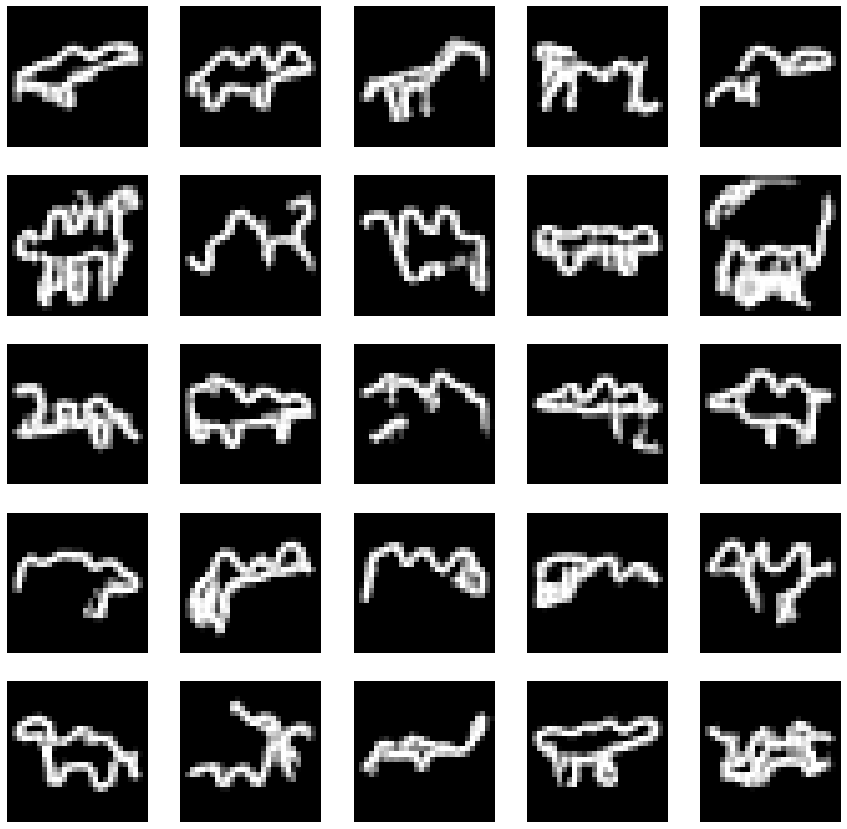

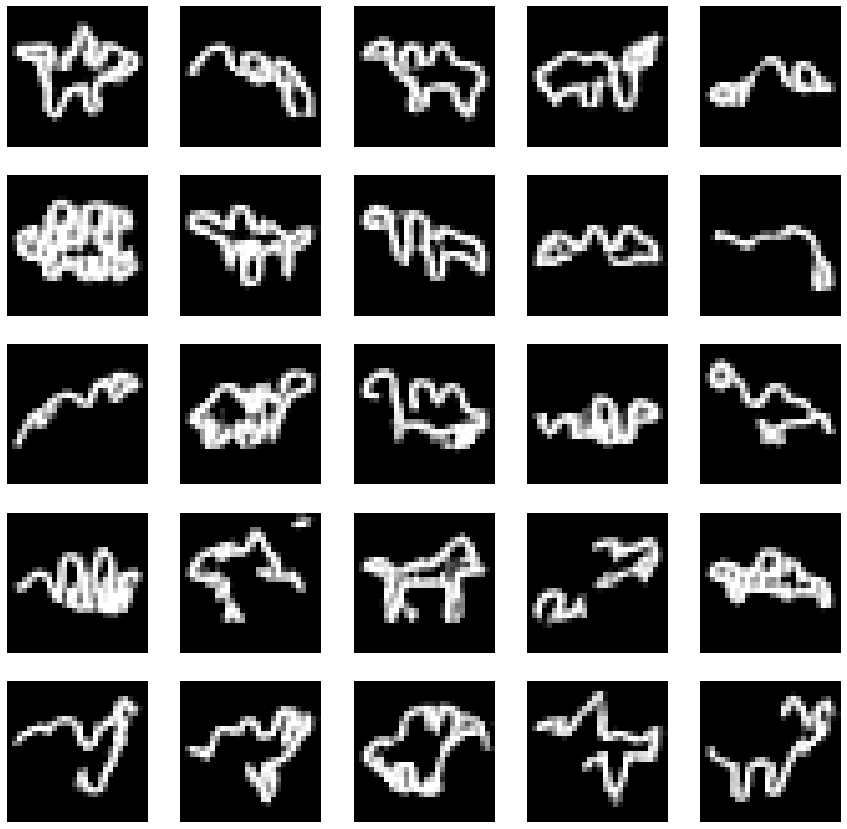

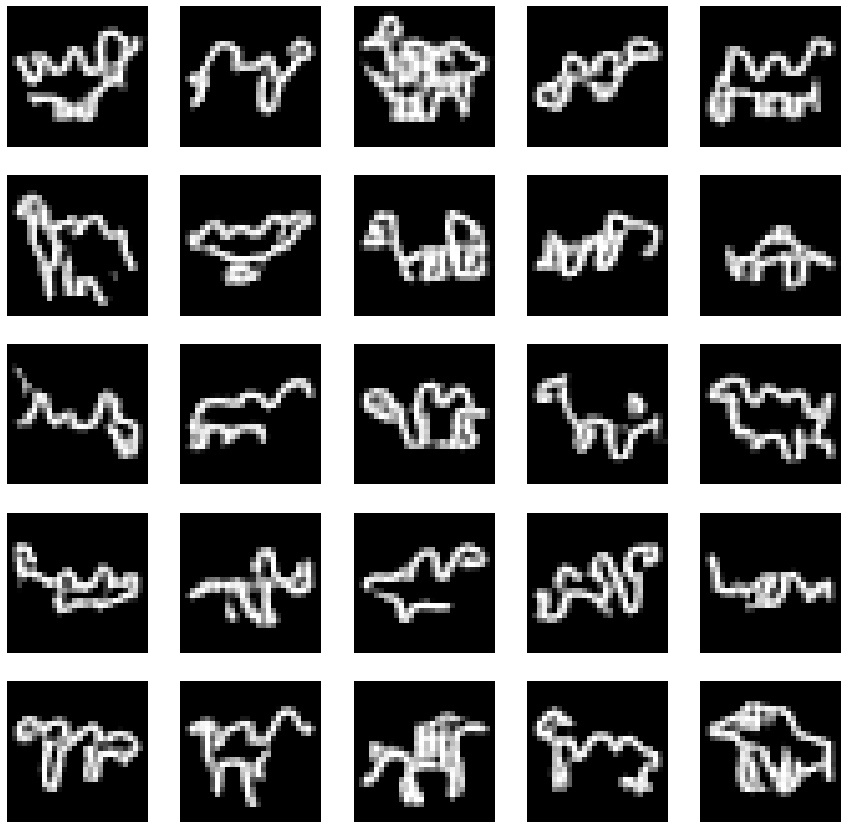

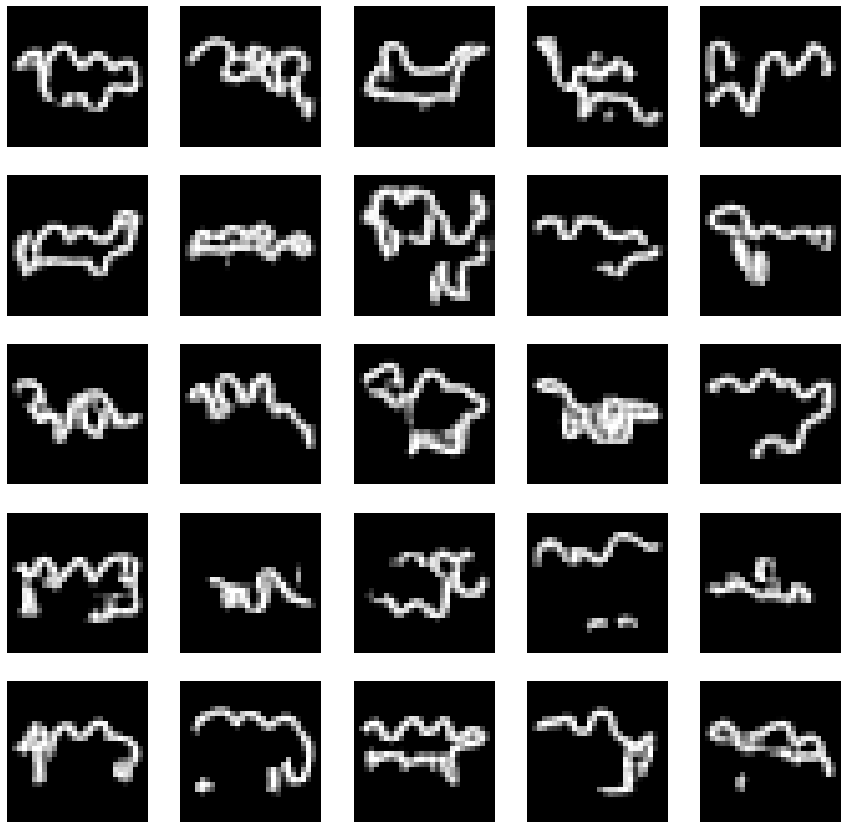

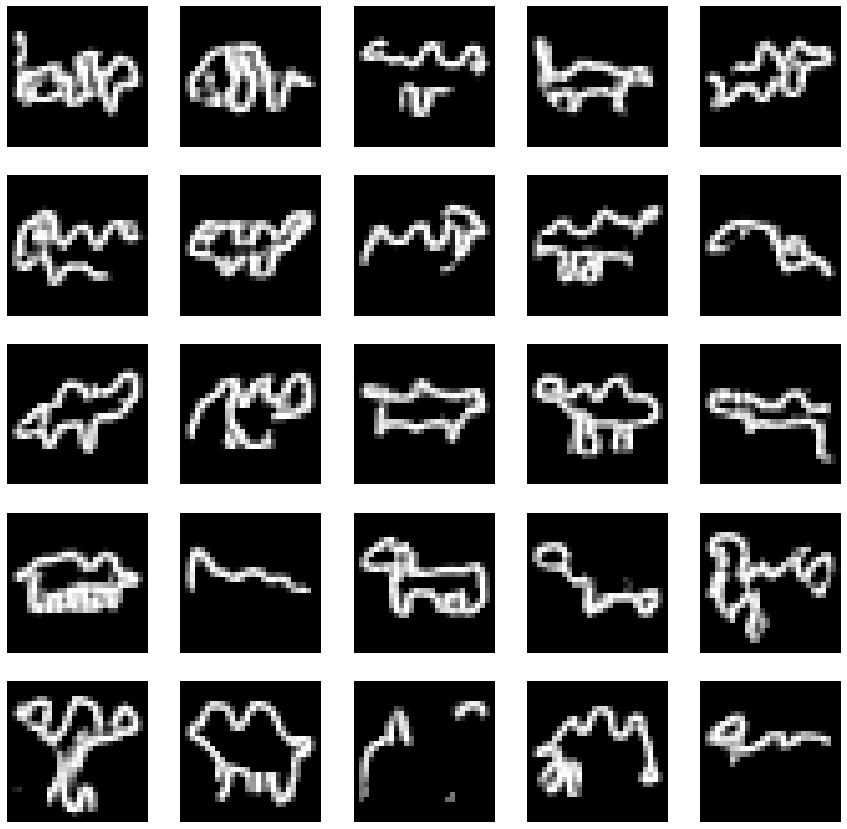

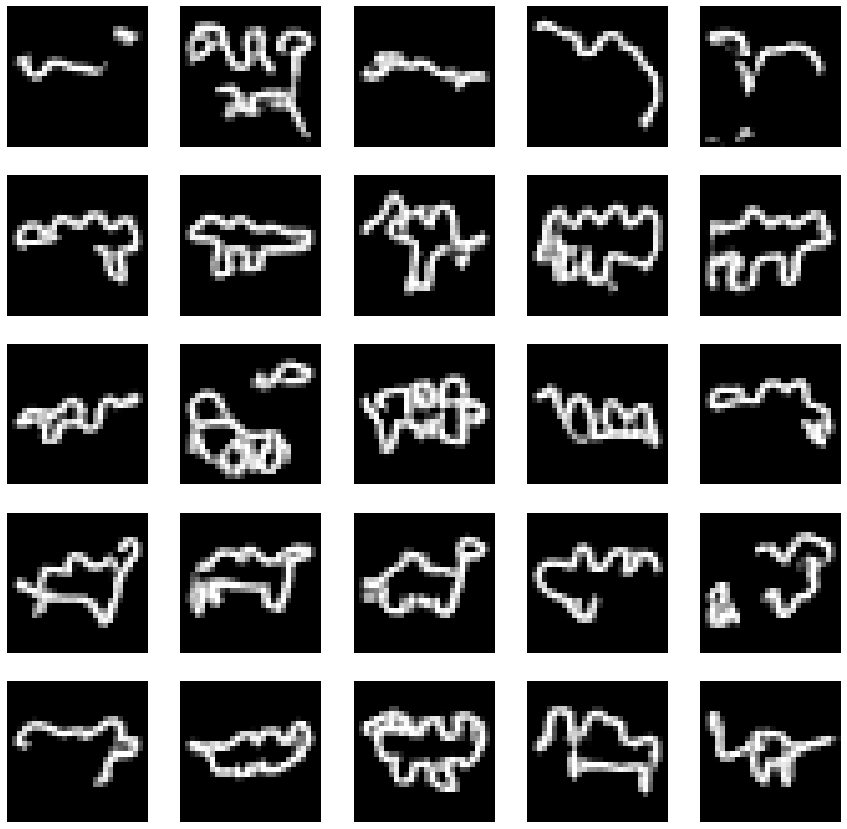

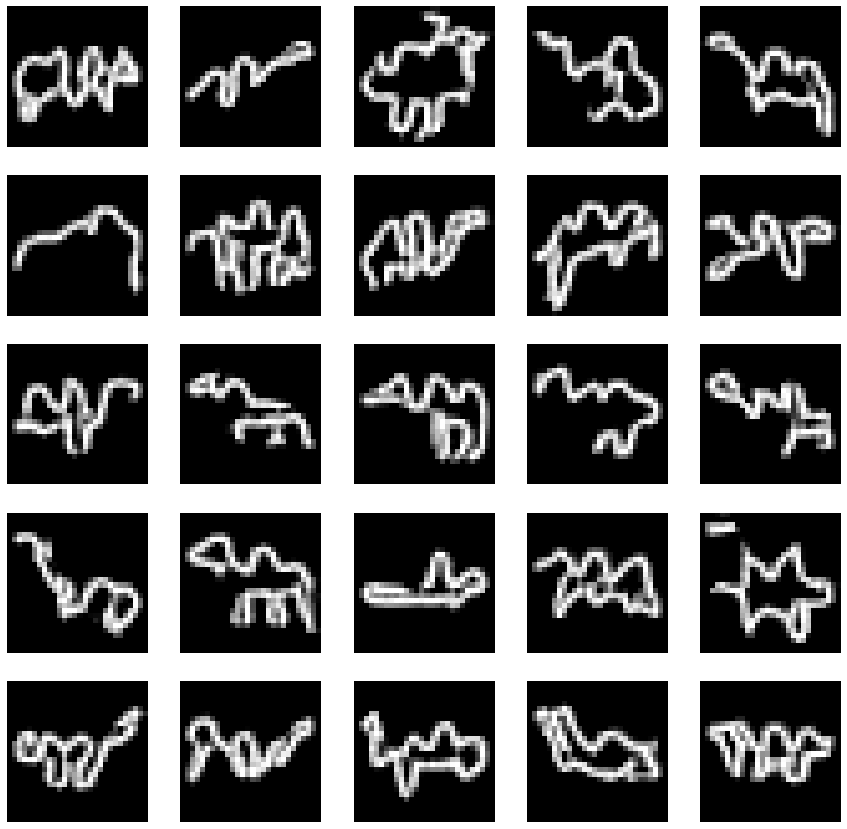

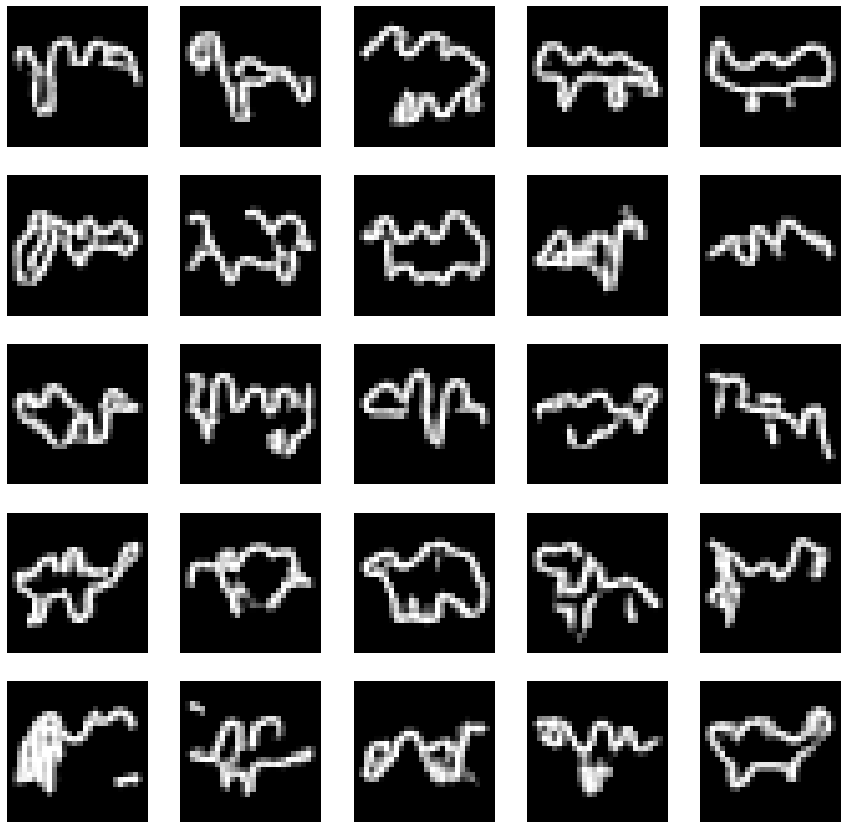

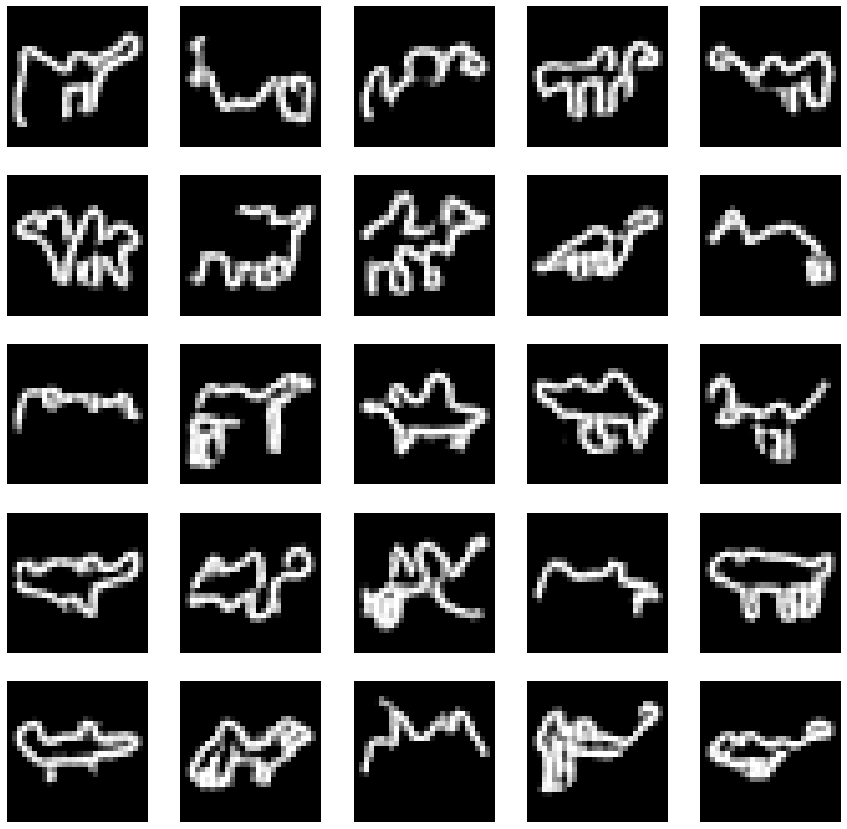

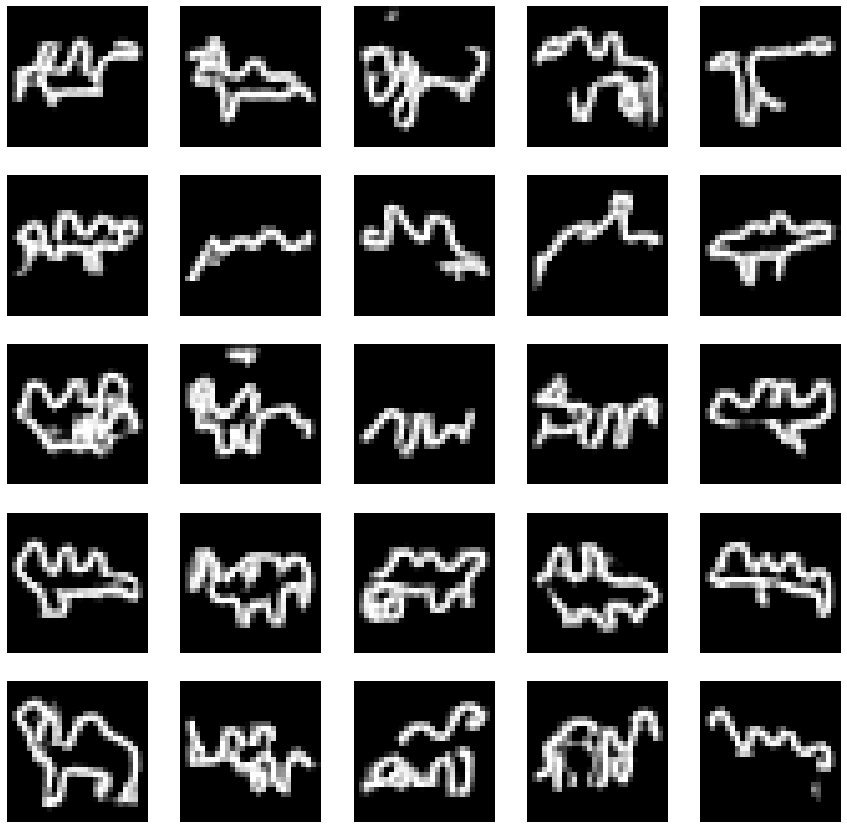

In [116]:
d_losses, g_losses = train(dataset,64,6000)

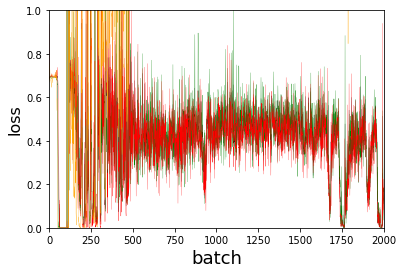

In [106]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 1)

plt.show()

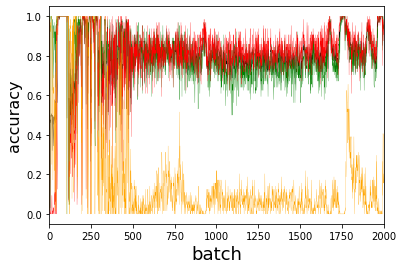

In [107]:

fig = plt.figure()
plt.plot([x[3] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()